# Explore embeddings

Load and explore embeddings from different methods


Install required packages:
```
uv add pyarrow nbformat plotly
```

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl

plt.style.use("seaborn-v0_8-whitegrid")

import sys
from pathlib import Path

sys.path.append(str(Path().absolute().parent))

import utilities

Load embeddings

In [2]:
from pathlib import Path

basepath = Path("../data/embeddings/")

movie_embeddings_dfs = {
    filepath.name.split(".")[0]: pl.read_parquet(filepath)
    for filepath in basepath.glob("**/*")
}

if 0:
    movie_embeddings_dfs = pl.concat(
        [
            pl.read_parquet(filepath).with_columns(
                name=pl.lit(filepath.name.split(".")[0])
            )
            for filepath in basepath.glob("**/*")
        ],
        how="vertical_relaxed",
    )

movie_embeddings_dfs

{'word2vec_20': shape: (50, 21)
 ┌─────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ movieId ┆ column_0  ┆ column_1  ┆ column_2  ┆ … ┆ column_16 ┆ column_17 ┆ column_18 ┆ column_19 │
 │ ---     ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ i64     ┆ f32       ┆ f32       ┆ f32       ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f32       │
 ╞═════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 1       ┆ 0.190849  ┆ -0.06542  ┆ 0.853075  ┆ … ┆ 0.137628  ┆ 0.675951  ┆ -0.292045 ┆ -0.25008  │
 │ 32      ┆ -0.283217 ┆ -0.413515 ┆ 0.247985  ┆ … ┆ -0.41274  ┆ 0.185459  ┆ 0.228888  ┆ -0.089739 │
 │ 47      ┆ -0.577756 ┆ 0.548198  ┆ 0.579472  ┆ … ┆ -0.127296 ┆ -0.114625 ┆ 0.190342  ┆ -0.170265 │
 │ 50      ┆ -0.682546 ┆ -0.266538 ┆ -0.316984 ┆ … ┆ -0.588395 ┆ -0.775543 ┆ -0.130429 ┆ 0.311047  │
 │ 110     ┆ 0.332171  ┆ -0.083185 ┆ -0.10537  ┆ … ┆ 0.2007

In [3]:
ratings_df = utilities.load_ratings()
movies_df = utilities.load_movies()
top_movie_ids = utilities.get_most_frequent_movies(ratings_df)
top_movies_df = movies_df.join(top_movie_ids, on="movieId")
labels = top_movies_df["title"].to_list()
top_movies_df

movieId,title,genres
i64,str,str
1,"""Toy Story (1995)""","""Adventure|Animation|Children|C…"
32,"""Twelve Monkeys (a.k.a. 12 Monk…","""Mystery|Sci-Fi|Thriller"""
47,"""Seven (a.k.a. Se7en) (1995)""","""Mystery|Thriller"""
50,"""Usual Suspects, The (1995)""","""Crime|Mystery|Thriller"""
110,"""Braveheart (1995)""","""Action|Drama|War"""
…,…,…
4993,"""Lord of the Rings: The Fellows…","""Adventure|Fantasy"""
5952,"""Lord of the Rings: The Two Tow…","""Adventure|Fantasy"""
7153,"""Lord of the Rings: The Return …","""Action|Adventure|Drama|Fantasy"""


### Cosine similarity

Use cosine similarity on embedding pairs to find similar titles.

In [4]:
from sklearn.metrics.pairwise import cosine_similarity


def get_embedding_vectors(movie_embeddings_df: pl.DataFrame) -> np.array:
    # limit to top movies only
    return (
        top_movies_df["movieId", "title"]
        .join(movie_embeddings_df, on="movieId", how="left")
        .drop(["movieId", "title"])
        .to_numpy()
    )


def get_cosine_similarities(movie_embeddings_df: pl.DataFrame) -> np.array:
    embedding_values = get_embedding_vectors(movie_embeddings_df)

    similarity_matrix = cosine_similarity(embedding_values)
    # limit to lower triangle only
    similarity_matrix[np.triu_indices(similarity_matrix.shape[0], k=0)] = np.nan

    return similarity_matrix

The strongest and weakest similarities:

In [5]:
for name, movie_embeddings_df in movie_embeddings_dfs.items():
    print(name)
    similarity_matrix = get_cosine_similarities(movie_embeddings_df)
    utilities.get_extreme_similarities(
        similarity_matrix=similarity_matrix, labels=labels, top_n=10
    )
    print()

word2vec_20
Most similar:
0.56 - Memento (2000), Fight Club (1999)
0.53 - Sixth Sense, The (1999), Good Will Hunting (1997)
0.49 - Indiana Jones and the Last Crusade (1989), Princess Bride, The (1987)
0.48 - American Beauty (1999), Usual Suspects, The (1995)
0.47 - Aladdin (1992), Speed (1994)
0.45 - Independence Day (a.k.a. ID4) (1996), Aladdin (1992)
0.44 - Batman (1989), True Lies (1994)
0.43 - Batman (1989), Toy Story (1995)
0.41 - Fight Club (1999), Fargo (1996)
0.41 - Speed (1994), Toy Story (1995)

Least similar:
-0.59 - Good Will Hunting (1997), Star Wars: Episode V - The Empire Strikes Back (1980)
-0.59 - Inception (2010), Independence Day (a.k.a. ID4) (1996)
-0.58 - Dark Knight, The (2008), Aladdin (1992)
-0.56 - Titanic (1997), Schindler's List (1993)
-0.55 - Shrek (2001), Shawshank Redemption, The (1994)
-0.53 - Lord of the Rings: The Return of the King, The (2003), Apollo 13 (1995)
-0.52 - Memento (2000), Fugitive, The (1993)
-0.52 - Indiana Jones and the Last Crusade (198

Plotting similarities for all 50x50 pairs:

word2vec_20
word2vec


/Users/stantoon/Documents/VariousProjects/github/data-analysis/neural_networks/movie_lens/utilities.py:86: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/stantoon/Documents/VariousProjects/github/data-analysis/neural_networks/movie_lens/utilities.py:86: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


tf_idf
nn


/Users/stantoon/Documents/VariousProjects/github/data-analysis/neural_networks/movie_lens/utilities.py:86: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/stantoon/Documents/VariousProjects/github/data-analysis/neural_networks/movie_lens/utilities.py:86: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


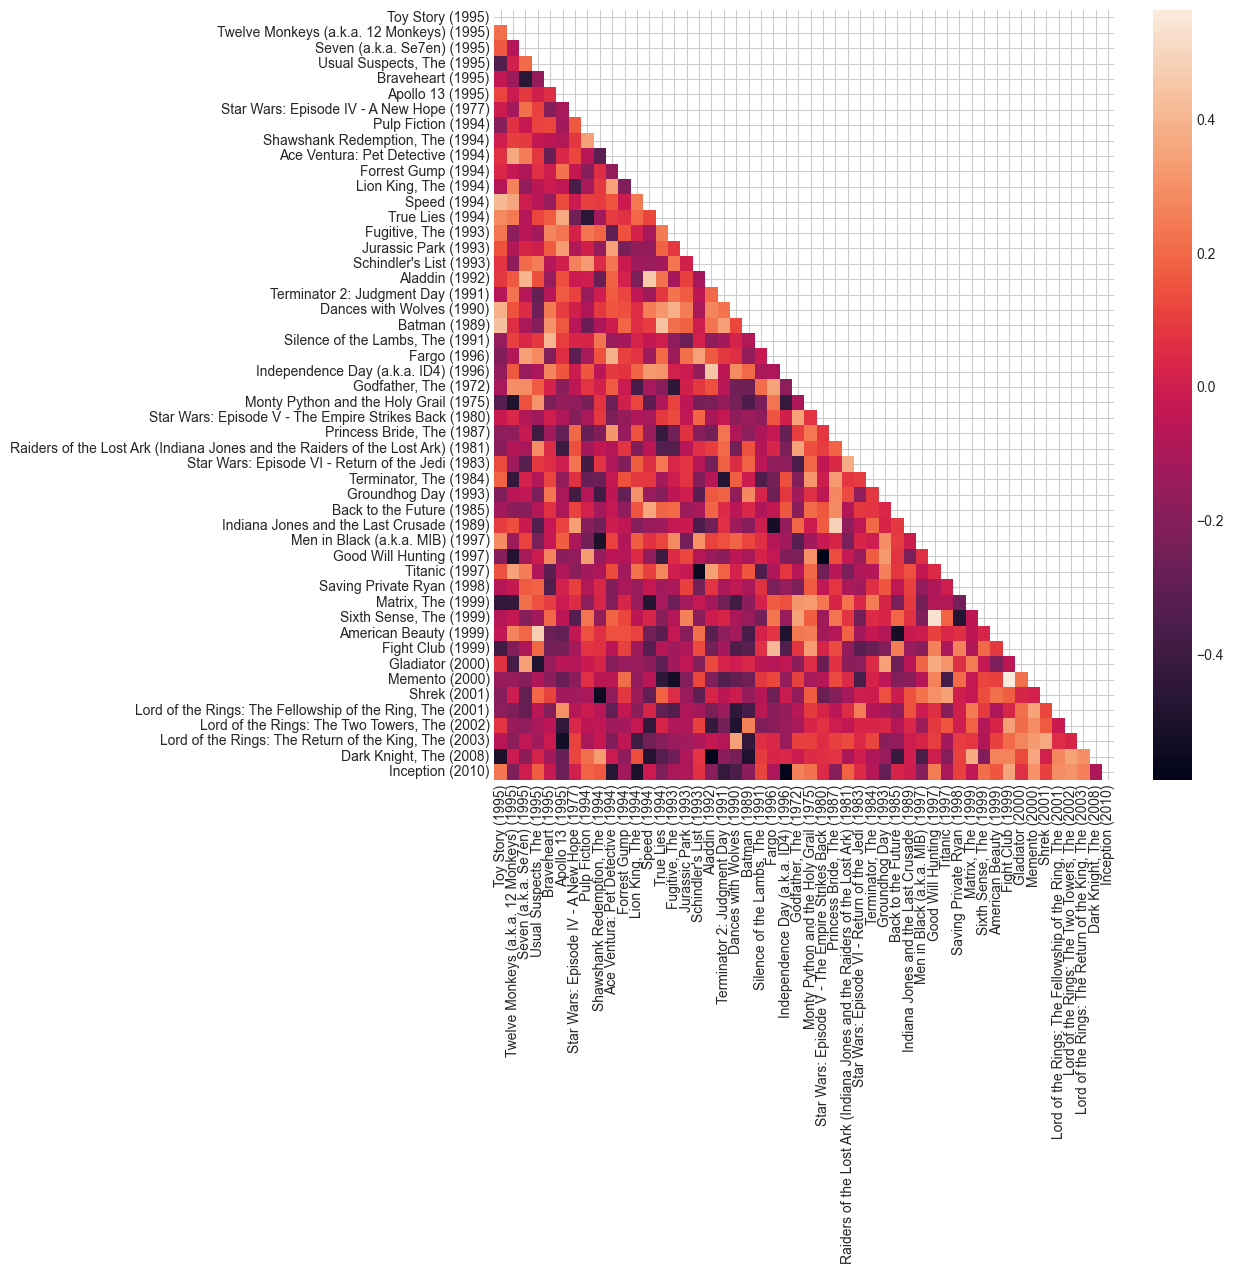

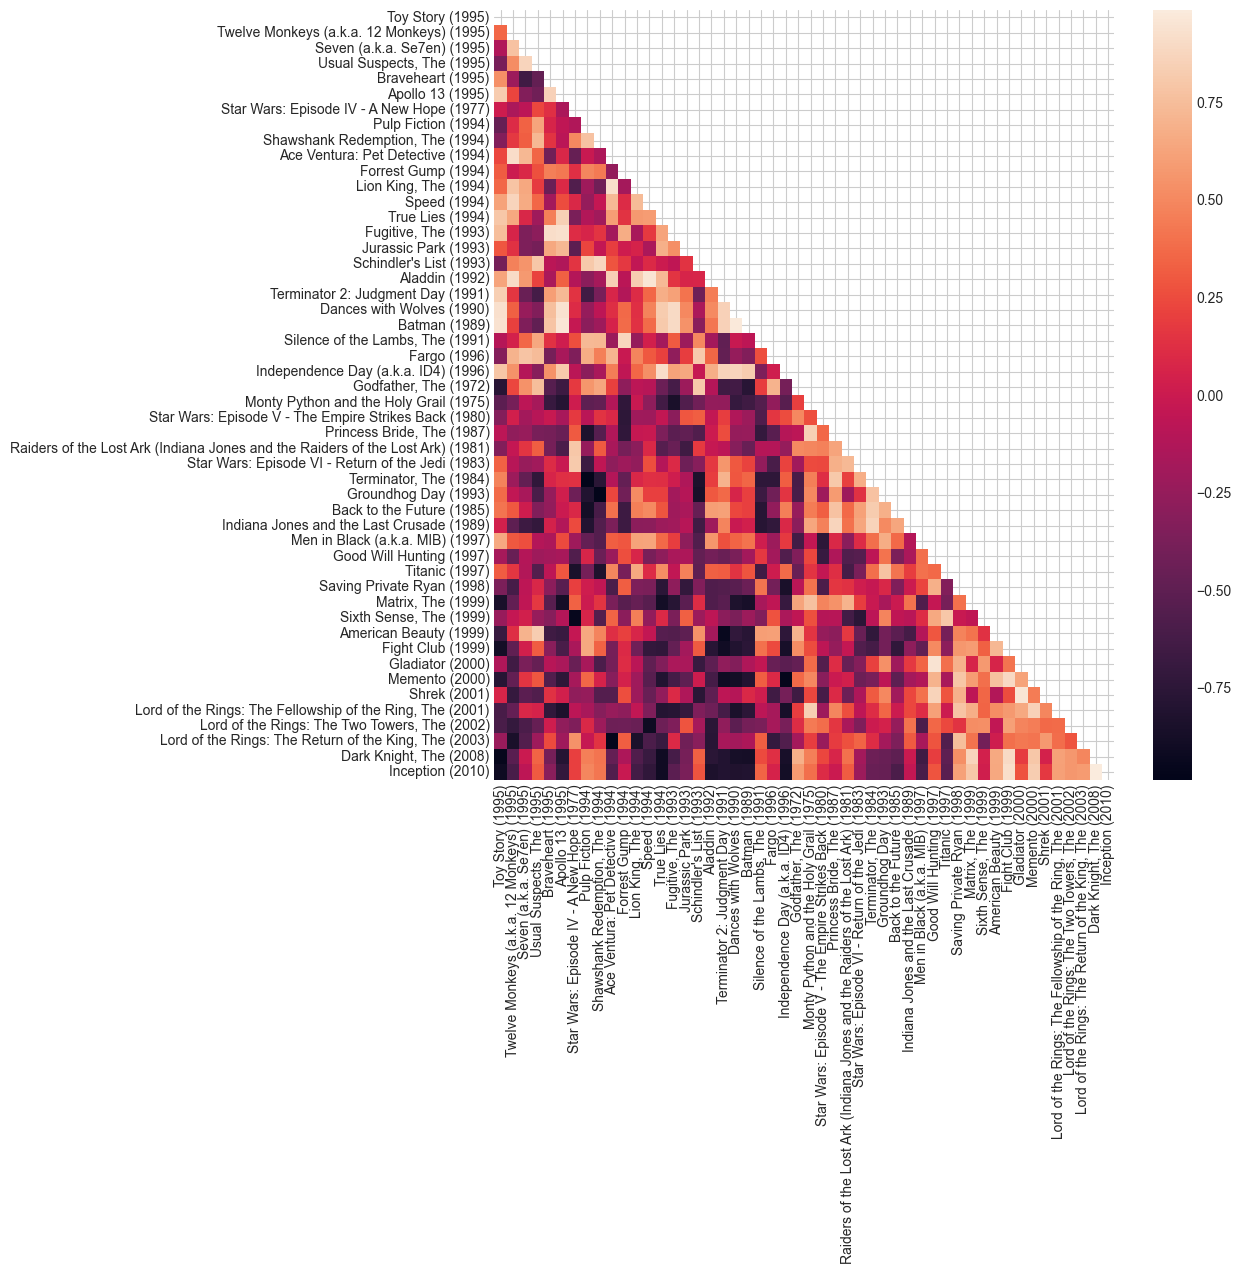

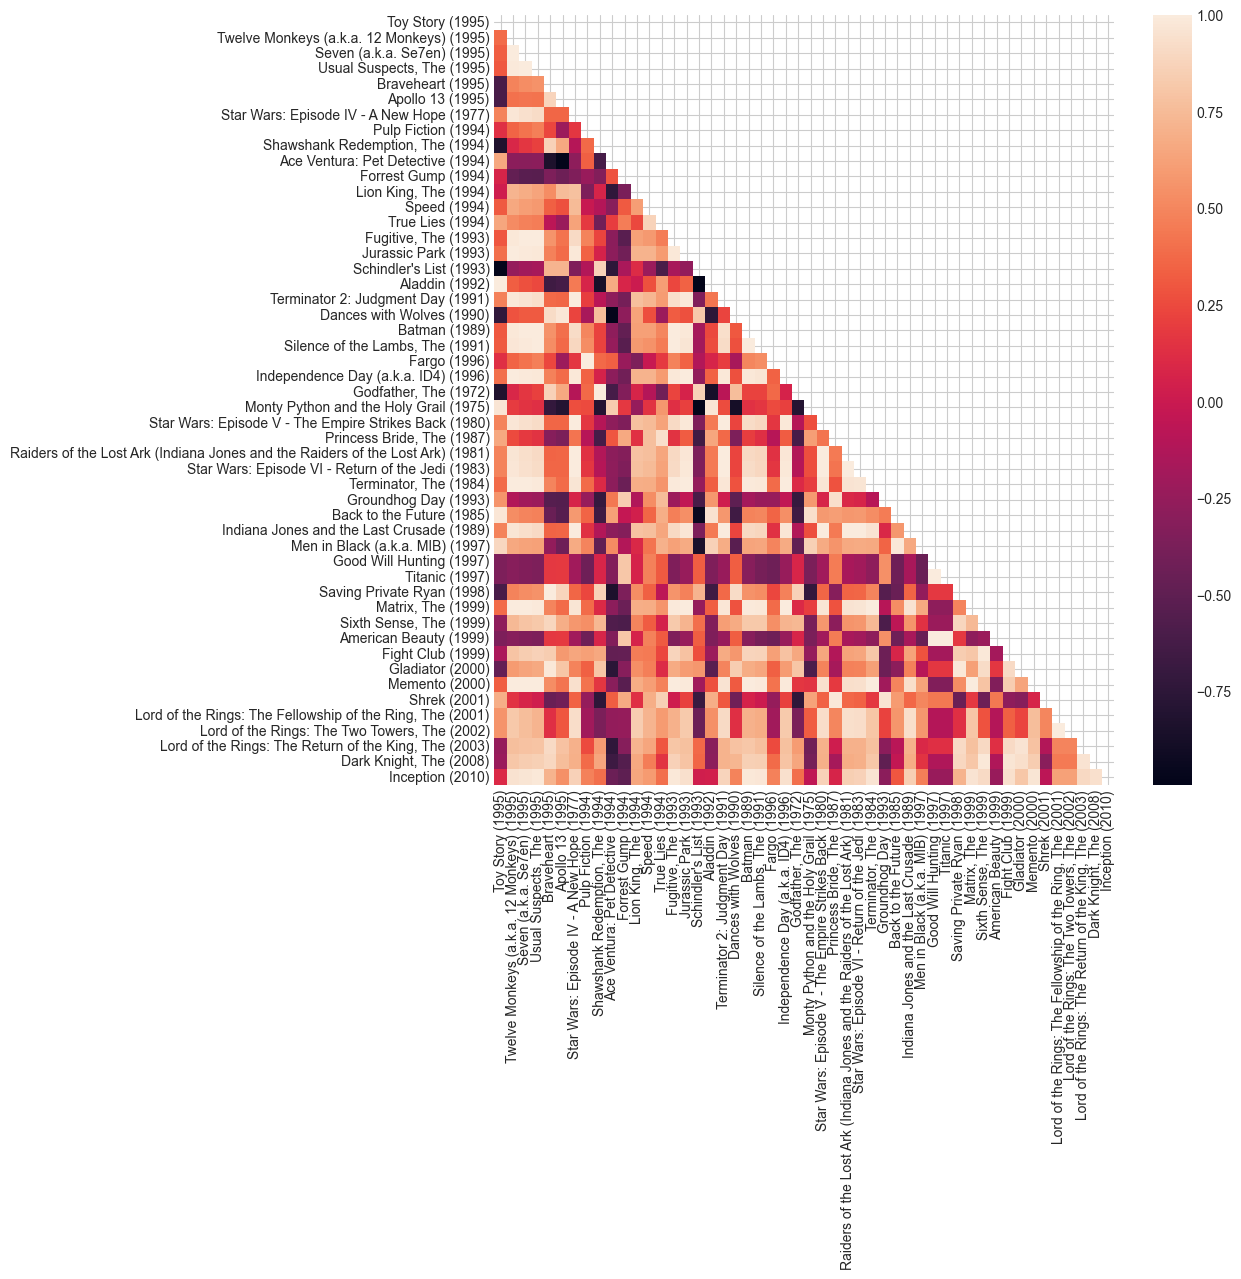

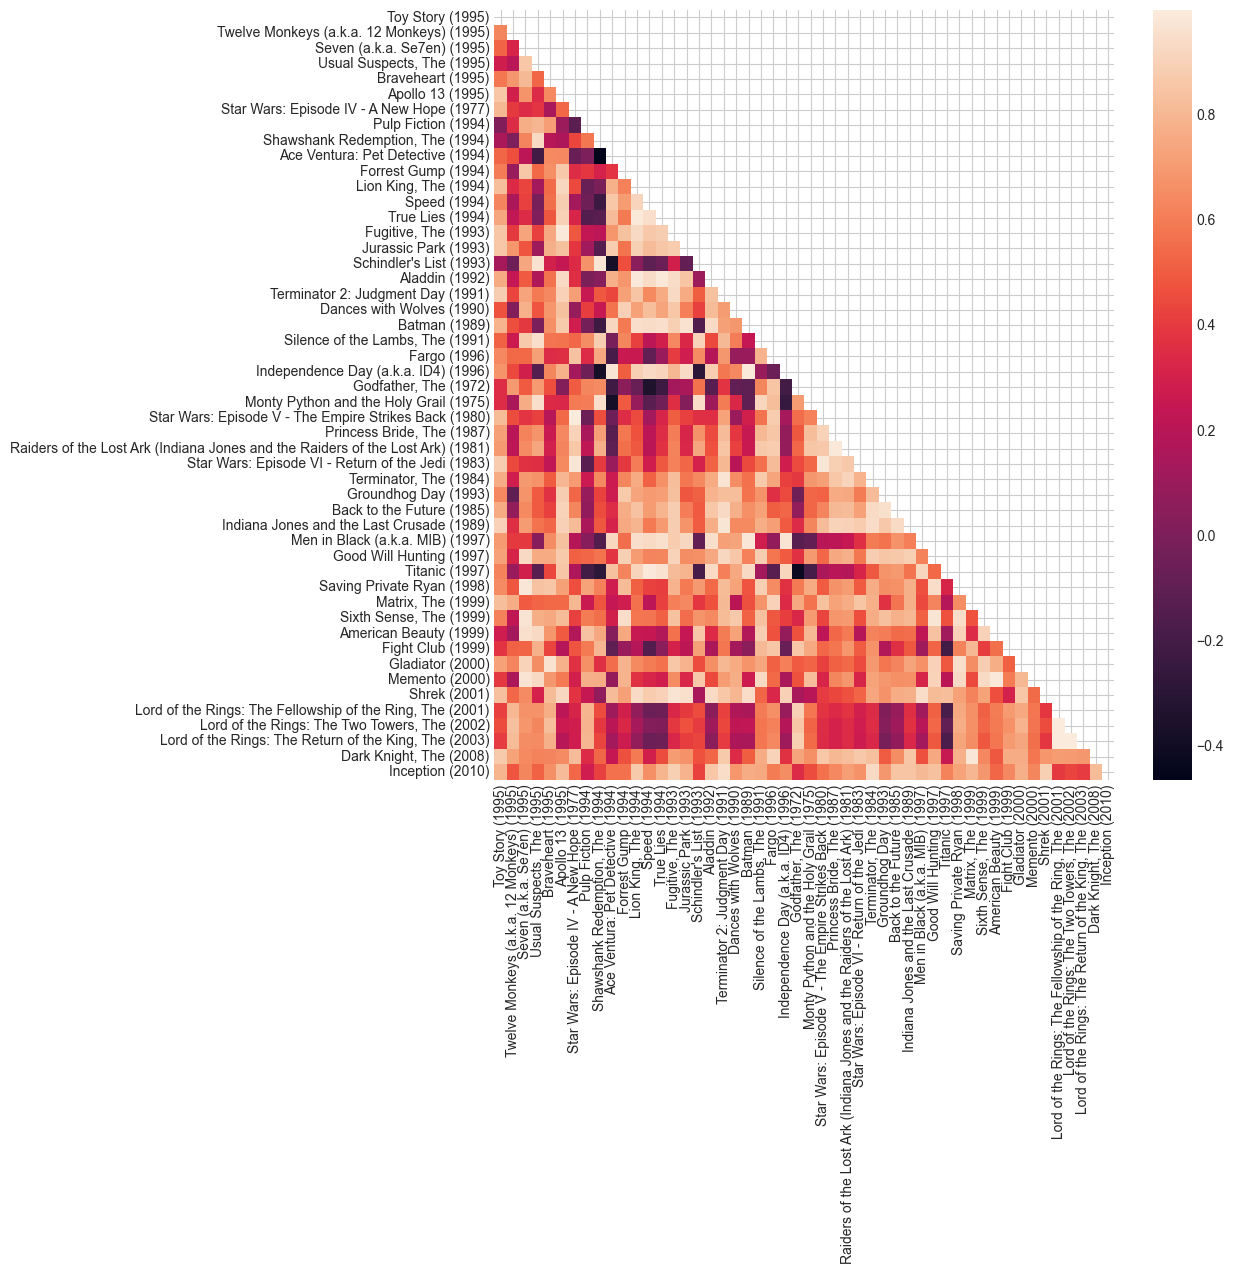

In [6]:
for name, movie_embeddings_df in movie_embeddings_dfs.items():
    print(name)
    similarity_matrix = get_cosine_similarities(movie_embeddings_df)

    utilities.plot_similarities(similarity_matrix=similarity_matrix, labels=labels)

### T-SNE clusters

In [7]:
import plotly.express as px
from sklearn.manifold import TSNE


def plot_tsne_scatter(movie_embeddings_df, name: str):
    tsne_df = top_movies_df["movieId", "title"].join(
        movie_embeddings_df, on="movieId", how="left"
    )

    embedding_vectors = tsne_df.drop(["movieId", "title"]).to_numpy()
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(embedding_vectors)
    tsne_df = tsne_df.with_columns(
        tsne_embeddings_0=tsne_embeddings[:, 0], tsne_embeddings_1=tsne_embeddings[:, 1]
    )

    fig = px.scatter(
        tsne_df.to_pandas(),
        x="tsne_embeddings_0",
        y="tsne_embeddings_1",
        hover_data=["title"],
        height=800,
        width=1000,
        template="seaborn",
        text="title",
        title=f"Embedding TSNE - {name}",
    )
    fig.show()


# plot_tsne_scatter(movie_embeddings_dfs["word2vec"], "word2vec")
# plot_tsne_scatter(movie_embeddings_dfs["tf_idf"], "tf-idf")
plot_tsne_scatter(movie_embeddings_dfs["nn"], "nn")

In [8]:
plot_tsne_scatter(movie_embeddings_dfs["word2vec_20"], "word2vec_20")